#### Import Libraries

In [1]:
import os, sys
import yfinance as yf
# import ta
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import date, timedelta, datetime
from itertools import product
from IPython.display import clear_output
import matplotlib.pyplot as plt
from csv import writer
import warnings
import talib as ta
import math
import re
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/telegram/utils/request.py:49: UserWarning: python-telegram-bot is using upstream urllib3. This is allowed but not supported by python-telegram-bot maintainers.
  warnings.warn(


In [2]:
def print_exception_detail(err, *args, **kwargs):
    exc_type, exc_obj, exc_tb = sys.exc_info()
    if len(args):
        for _arg in args:
            print(_arg)
    print(f"Error Message: {err}")
    print(f"Error at line number: {exc_tb.tb_lineno}")

#### Tickers of S&P100 and Treasury Bond Rates of 1day frequency

In [3]:
treasury_bond = ["^TYX"]
smp100 = ["^OEX"]

ticker = ["NVDA","AAPL","MSFT","AMZN","GOOGL","GOOG","META","TSLA","AVGO","COST","NFLX","ASML","TMUS","AMD","CSCO","PEP","ADBE","LIN","AZN","TXN","QCOM	","INTU","ISRG","AMGN	","CMCSA","PDD","BKNG","AMAT","ARM","HON","VRTX","PANW","ADP","MU","GILD","ADI","SBUX","MELI","INTC","LRCX","KLAC","MDLZ","ABNB","REGN","CTAS","SNPS","CDNS","PYPL","CRWD","MRVL","MAR","CEG","CSX","ORLY","DASH","WDAY","CHTR","ADSK","FTNT","TTD","ROP","PCAR","NXPI","TEAM","FANG","MNST","CPRT","PAYX","AEP","ODFL","ROST","FAST","KDP","DDOG","EA","BKR","KHC","MCHP","VRSK","GEHC","CTSH","LULU","EXC","XEL","CCEP","IDXX","ON","CSGP","ZS","TTWO","ANSS","CDW","DXCM","BIIB","GFS","ILMN","MDB","WBD","MRNA","DLTR","WBA"]
ticker = [_t.strip() for _t in ticker]

##### Methods to download data

In [19]:
def download_data(ticker, interval='1d'):
    # dt_range = pd.date_range('2019-12-31', '2020-12-31', freq='6m') 
    # define start and end date
    # end_date = datetime.now()-timedelta(days=30)
    # start_date = end_date - timedelta(days=390)

    end_date = datetime.now() #- timedelta(days=30)
    start_date = end_date - timedelta(days=1855)

    # extract data from yahoo finanace
    btc_price = vbt.YFData.download(
    ticker,
    interval=interval,
    start = start_date,
    end = end_date,
    missing_index='drop').get("Close")
    df = pd.DataFrame(btc_price)
    df.rename(columns={"Close":ticker}, inplace=True)
    df.head()
    df.index=df.index.strftime("%Y-%m-%d")
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
# df = pd.DataFrame()
# for _t in ticker:
#     try:
#         if df.empty:
#             df=download_data(_t)
#         else:
#             df1 = pd.DataFrame()
#             df1 = download_data(_t)
#             # per_chg = len(df.index.difference(df2.index)) #/len(df.index))*100
#             # print(per_chg)
#             # if per_chg<518:
#             df = pd.merge(df, df1, left_index=True, right_index=True, how='inner')  # Only keep matching rows
#     except Exception as err:
#         print_exception_detail(err)

In [30]:
# # # Treasury bill data downloaded and percentage change on a window of 20
# df_treasury = download_data(treasury_bond[0])

# # # SMP 100 data download
# df_smp100 = download_data(smp100[0])

In [31]:
# # # Merge ticker price with treasury bill and smp100 

# df = pd.merge(df, df_treasury, left_index=True, right_index=True, how="inner")
# df = pd.merge(df, df_smp100, left_index=True, right_index=True, how="inner")

In [42]:
# if "^TYX_x" in df.columns:
#     df.drop(columns=["^TYX_x"], inplace=True)
# if "^TYX_y" in df.columns:
#     df.drop(columns=["^TYX_y"], inplace=True)

# df_treasury[f"{treasury_bond[0]}_pct_change_20"] = df_treasury[f"{treasury_bond[0]}"].pct_change(20)

##### Percentile Method

$
 \frac{rank of an element}{total number of element}\,* 100 
$

In [10]:
def percentile(window):
    index = window.index[-1]
    window = window.rank(method="min", ascending=True).apply(lambda x: (x/20)*100)
    return window.loc[index]

### Indicator

##### There are two sets of indicators used
1. ##### For timing the entry and exit; RSI, Stochastic and Bollingier
2. ##### For selection of best stocks; Performance Rank and Sharpe Ratio
3. ##### As an additional support to our decision; Sentiment of S&P and Slope of the assets for last 1 or 2 weeks

#### Stochastic Indicator

Stochastic indicator is a momentum indicator that uses support and resistance levels as an oscillator

%K = (Current Close - Lowest Low)/(Highest High - Lowest Low) * 100
%D = 3-day SMA of %K

We will focus on the stock with %D-Slow turnaround in the bottom as they will signal an entry. 
For normalization of the historic %D, the percentile of value wrt last 20 days is evaluated.

#### RSI Indicator


#### Bollingier

In [34]:
def stochastic_k(price, period):
    index = price.index[-1]
    sorted_price = price.sort_values(ascending=True)
    closing_price = price.loc[index]
    highest_high = sorted_price.iloc[-1]
    lowest_low = sorted_price.iloc[0]
    per_k = (closing_price - lowest_low)/(highest_high-lowest_low)*100
    return per_k

In [35]:
# To evaluate zscore using a penalized version error function
def zscore(x):
    return (math.erf(6-(12*(x/100))))

In [36]:
def rank_asset(row):
    size = len(row)
    sorted_row = row.sort_values(ascending=True) 
    buy_recom = [{col[:col.find('_')]:sorted_row[col]} for col in list(sorted_row[math.floor(size*.75):].index)]
    sell_recom = [{col[:col.find('_')]:sorted_row[col]} for col in list(sorted_row[:math.floor(size*.25)].index)]
    return buy_recom, sell_recom

In [37]:
def return_interval(window, ticker, mov):
    if mov=="up":
        # print(window[f"{ticker}_std_20"].div(window[f"{ticker}_mean_20"]))
        return ((window[f"{ticker}_expected_upward_movement"]-window[f"{ticker}_std_by_mean"]), (window[f"{ticker}_expected_upward_movement"]+window[f"{ticker}_std_by_mean"]))
    else:
        return ((window[f"{ticker}_expected_downward_movement"]-window[f"{ticker}_std_by_mean"]), (window[f"{ticker}_expected_downward_movement"]+window[f"{ticker}_std_by_mean"]))

In [59]:
for _t in ticker:
    try:
        print(_t)
        # # Technical Indicator
        # # -------------------

        # mean
        df[f"{_t}_mean_20"]=df[f"{_t}"].rolling(window=20).mean()
        
        # # RSI of last n days
        # df[f"{_t}_rsi_20"] = ta.RSI(df[_t], timeperiod=20)
        # # Percentile of RSI value wrt last n days. This will give us the respective position
        # df[f"{_t}_rsi_20_percentile_last_20"]=df[f"{_t}_rsi_20"].rolling(window=20).apply(percentile)

        # # Stochastic of last n days
        # df[f"{_t}_sto_fast_20"]=df[f"{_t}"].rolling(window=20).apply(lambda x: stochastic_k(x, 20))
        # df[f"{_t}_sto_slow_20"]=ta.SMA(df[f"{_t}_sto_fast_20"],3)
        # # Percentile of Stochastic slow value wrt last n days. This will give us the respective position
        # df[f"{_t}_sto_slow_20_percentile_last_20"]=df[f"{_t}_sto_slow_20"].rolling(window=20).apply(percentile)

        # # Bollingier Indicator for last n days
        # df[f"{_t}_sma_20"] = ta.SMA(df[f"{_t}"],20)
        # df[f"{_t}_std_20"] = df[f"{_t}"].rolling(window=20).std()
        # # Lamda = (P(t) - SMA_20)/Std_20
        # df[f"{_t}_lamda_20"] = (df[f"{_t}"] - df[f"{_t}_sma_20"])/df[f"{_t}_std_20"]
        # # Percentile of lambda value wrt last n days. This will give us the respective position
        # df[f"{_t}_lamda_20_percentile_lst_20"] = df[f"{_t}_lamda_20"].rolling(window=20).apply(percentile)

        # # z- scores
        # # ---------

        # # z-score of RSI
        # df[f"{_t}_rsi_20_zscore"] = df[f"{_t}_rsi_20_percentile_last_20"].apply(zscore)
        # # z-score of Stochastic Slow
        # df[f"{_t}_sto_slow_20_zscore"] = df[f"{_t}_sto_slow_20_percentile_last_20"].apply(zscore)
        # # z-score of Lambda - a derived bollinger value
        # df[f"{_t}_lamda_20_zscore"] = df[f"{_t}_lamda_20_percentile_lst_20"].apply(zscore)

        # # Mean of z-scores of RSI, Stochastic slow and Lambda
        # # z-score tends to 1 means indication of reversal at the bottom 
        # df[f"{_t}_mean_zscore"] = (df[f"{_t}_rsi_20_zscore"] + df[f"{_t}_sto_slow_20_zscore"] + df[f"{_t}_lamda_20_zscore"])/3

        # # Selection Indicators
        # # --------------------

        # # Sharpe Ratio - This will be evaluated for long period
        # df[f"{_t}_pct_change_20"] = df[f"{_t}"].pct_change(20)
        # df[f"{_t}_return_std_20"] = df[f"{_t}_pct_change_20"].rolling(window=20).std()
        df[f"{_t}_sharpe_ratio_t"] = (df[f"{_t}_pct_change_20"] - df[f"{treasury_bond[0]}_pct_change_20"])/df[f"{_t}_return_std_20"]
        df[f"{_t}_sharpe_ratio"] = ((1 - (df[f"{_t}_sharpe_ratio_t"] - df[f"{_t}_sharpe_ratio_t"].min())/(df[f"{_t}_sharpe_ratio_t"].max() - df[f"{_t}_sharpe_ratio_t"].min()))*100).apply(zscore)

        # # Performance Rank - This will be evaluated for last 7 days
        df[f"{_t}_performance_rank_t"] = ((df[f"{_t}"] - df[f"{_t}"].shift(7))/df[f"{_t}"])*100
        df[f"{_t}_performance_rank"] = ((1 - (df[f"{_t}_performance_rank_t"] - df[f"{_t}_performance_rank_t"].min())/(df[f"{_t}_performance_rank_t"].max() - df[f"{_t}_performance_rank_t"].min()))*100).apply(zscore)

        # # Slope of stock at each timestamp; evaluated {[(P(t)+P(t-1))-(P(t-7)+P(t-8))]/2*P(t)}
        # df[f"{_t}_shift1"] = df[f"{_t}"].shift(1)
        # df[f"{_t}_shift6"] = df[f"{_t}"].shift(6)
        # df[f"{_t}_shift7"] = df[f"{_t}"].shift(7)
        # df[f"{_t}_slope"] = ((df[f"{_t}"] + df[f"{_t}_shift1"])-(df[f"{_t}_shift6"] + df[f"{_t}_shift7"]))/(2*df[f"{_t}"] )

        # Percentage expected increase wrt to upper bollingier band
        df[f"{_t}_expected_upward_movement"] = (((df[f"{_t}_sma_20"] + 2 * df[f"{_t}_std_20"])-(df[f"{_t}"]))/(df[f"{_t}"]))
        df[f"{_t}_expected_downward_movement"] = (((df[f"{_t}"]) - (df[f"{_t}_sma_20"] - 2 * df[f"{_t}_std_20"]))/(df[f"{_t}"]))

        # confidence interval i.e 1 std deviation
        df[f"{_t}_std_by_mean"] = df[f"{_t}_std_20"].div(df[f"{_t}_mean_20"])
        df[f"{_t}_expected_upward_movement_interval"] = df.apply(return_interval, args=(_t, "up"), axis=1)
        df[f"{_t}_expected_downward_movement_interval"] = df.apply(return_interval, args=(_t, "down"), axis=1)

        # Create three separate set : Top quartile set for buy and low quartile set for sell

        # Set of stocks on mean z-score
        df[["buy_recom_zscore", "sell_recom_zscore"]] = \
                df[[col for col in df.columns if re.search(".*mean_zscore$", col)]].apply(rank_asset, axis=1, \
                        result_type='expand')
        
        # # Set of stocks on the sharpe ratio
        df[["buy_recom_sharpe", "sell_recom_sharpe"]] = \
                df[[col for col in df.columns if re.search(".*sharpe_ratio$", col)]].apply(rank_asset, axis=1, result_type='expand')
        
        # # Set of stocks on the sharpe ratio
        df[["buy_recom_perf", "sell_recom_perf"]] = \
                df[[col for col in df.columns if re.search(".*performance_rank$", col)]].apply(rank_asset, axis=1, result_type='expand')
    except Exception as err:
        print_exception_detail(err)
        sys.exit()
    

NVDA
AAPL
MSFT
AMZN
GOOGL
GOOG
META
TSLA
AVGO
COST
NFLX
ASML
TMUS
AMD
CSCO
PEP
ADBE
LIN
AZN
TXN
QCOM
INTU
ISRG
AMGN
CMCSA
PDD
BKNG
AMAT
ARM
HON
VRTX
PANW
ADP
MU
GILD
ADI
SBUX
MELI
INTC
LRCX
KLAC
MDLZ
ABNB
REGN
CTAS
SNPS
CDNS
PYPL
CRWD
MRVL
MAR
CEG
CSX
ORLY
DASH
WDAY
CHTR
ADSK
FTNT
TTD
ROP
PCAR
NXPI
TEAM
FANG
MNST
CPRT
PAYX
AEP
ODFL
ROST
FAST
KDP
DDOG
EA
BKR
KHC
MCHP
VRSK
GEHC
CTSH
LULU
EXC
XEL
CCEP
IDXX
ON
CSGP
ZS
TTWO
ANSS
CDW
DXCM
BIIB
GFS
ILMN
MDB
WBD
MRNA
DLTR
WBA


In [62]:
# # Save the file
# df.to_csv("out_2024_11_13_1251.csv")

In [63]:
# df = pd.read_csv('out.csv', index_col='Date', parse_dates=True)
# df.to_csv("out_en_utf.csv", encoding='utf-8', index=False, header=True)

In [101]:
for i in df.columns:
    if 'MDB' in i:
        print(i)

MDB
MDB_rsi_20
MDB_rsi_20_percentile_last_20
MDB_sto_fast_20
MDB_sto_slow_20
MDB_sto_slow_20_percentile_last_20
MDB_sma_20
MDB_std_20
MDB_lamda_20
MDB_lamda_20_percentile_lst_20
MDB_rsi_20_zscore
MDB_sto_slow_20_zscore
MDB_lamda_20_zscore
MDB_mean_zscore
MDB_pct_change_20
MDB_return_std_20
MDB_sharpe_ratio
MDB_performance_rank
MDB_shift1
MDB_shift6
MDB_shift7
MDB_slope
MDB_mean_20
MDB_sharpe_ratio_t
MDB_performance_rank_t
MDB_expected_upward_movement
MDB_expected_downward_movement
MDB_std_by_mean
MDB_expected_upward_movement_interval
MDB_expected_downward_movement_interval


In [65]:
df.dropna(inplace=True)

In [67]:
df[["NVDA_expected_upward_movement", "NVDA_expected_upward_movement_interval"]].tail()

,NVDA_expected_upward_movement,NVDA_expected_upward_movement_interval
Date,,
2024-11-01,0.075515,"(0.044284086847466646, 0.1067457472070577)"
2024-11-04,0.064724,"(0.03789937202441962, 0.09154868878382574)"
2024-11-05,0.036028,"(0.01020047585651837, 0.06185573880491675)"
2024-11-06,0.002424,"(-0.024597816791777263, 0.029446590618765395)"
2024-11-07,-0.007408,"(-0.038283224925790074, 0.023467523557181885)"


#### -------------------data preperation complete------------------------------------

### Selection of Stocks
### ----------------------------------------------------

#### set selected for portfolio stocks

In [70]:
df["set_tech"] = df["buy_recom_zscore"].apply(lambda x : {list(_d.keys())[0] for _d in x})
df["set_sharpe"] = df["buy_recom_sharpe"].apply(lambda x : {list(_d.keys())[0] for _d in x})
df["set_perf"] = df["buy_recom_perf"].apply(lambda x : {list(_d.keys())[0] for _d in x})

In [71]:
df["tech_inter_sharpe"] = df[["set_tech", "set_sharpe"]].apply(lambda x : x["set_tech"].intersection(x["set_sharpe"]), axis=1)
df["tech_inter_perf"] = df[["set_tech", "set_perf"]].apply(lambda x : x["set_tech"].intersection(x["set_perf"]), axis=1)
df["sharpe_inter_perf"] = df[["set_sharpe", "set_perf"]].apply(lambda x : x["set_sharpe"].intersection(x["set_perf"]), axis=1)
df["tech_inter_sharpe_inter_perf"] = df[["set_tech","set_sharpe","set_perf"]].apply(lambda x : (x["set_tech"].intersection(x["set_perf"]).intersection(x["set_sharpe"])), axis=1)

#### set of randomly selected stocks

In [72]:
import random

def return_rand_ticker(window, ticker, num_of_rand):
    return random.sample(ticker, num_of_rand)
    
df["random_selection"] = df.apply(return_rand_ticker, args=(ticker, 10), axis=1)

In [73]:
df.dropna(inplace=True)

#### Backtesting

In [106]:
blacklit_df = df.iloc[-120:]

In [107]:
buy_recom_col = [col for col in df.columns if re.search(".*buy_recom.*", col)]
set_col = [col for col in df.columns if re.search(".*set.*", col)]
set_inter_col = [col for col in df.columns if re.search(".*inter.*", col)]
score_col = [col for col in df.columns if re.search(".*_mean_zscore.*|.*_performance_rank$|.*_sharpe_ratio$|.*slope$|.*expected.*", col)]

In [104]:
# score_col

In [108]:
blacklit_df = blacklit_df[buy_recom_col+set_col+set_inter_col+score_col+ticker+smp100+["random_selection"]]

Hierarchy of sets to be seen while searching for stocks:

1. tech_inter_sharpe_inter_perf
2. tech_inter_sharpe
3. sharpe_inter_perf
4. tech_inter_perf
5. set_sharpe

If User wants a portfolio of 10 stocks, the portfolio building logic would be

1. find the number of stocks in the given hierarchy of sets, starting from top if we get stocks say `n`
2. if `n`>10 : find the top 10 using cumulative score of (zscore + performance_rank + sharpe_ratio + slope + sentiment)
3. if `n`==10: no further search required
4. if `n`<10: take all the stocks from the current set, then look for the remaining stocks in the next set and repeat steps 1..4

In [84]:
from collections import OrderedDict

In [80]:
# check for 
num_of_stock = 10

def return_view_and_interval(list_of_stock, window):
    score_dict = {_l:0 for _l in list_of_stock}
    # for k, v in score_dict.items():
    for k in list_of_stock:
        if window[f"{k}_slope"]>0:
            score_dict[k] = score_dict[k] + window[f"{k}_mean_zscore"] + window[f"{k}_sharpe_ratio"] + window[f"{k}_performance_rank"]
            score_dict[k] = window[f"{k}_expected_upward_movement"] * score_dict[k]/3
        else:
            del score_dict[k]
    return score_dict

In [85]:
def return_portfolio_view_dict(window):
    od = OrderedDict()
    od['tech_inter_sharpe_inter_perf'] = window["tech_inter_sharpe_inter_perf"]
    od['tech_inter_sharpe'] = window["tech_inter_sharpe"]
    od['sharpe_inter_perf'] = window["sharpe_inter_perf"]
    od['tech_inter_perf'] = window["tech_inter_perf"]
    od['set_sharpe'] = window["set_sharpe"]
    
    portfolio = []
    
    for key, value in od.items():
        if value:
            score_dict = return_view_and_interval(list(value), window)
            sorted_stock = sorted(score_dict, key=score_dict.get, reverse=True)

            if len(portfolio)>=10:
                portfolio_dict = return_view_and_interval(portfolio, window)
                return portfolio_dict
            else:
                len_diff = num_of_stock-len(portfolio)
                if len_diff:
                    portfolio.extend(sorted_stock[:len_diff])

In [144]:
blacklit_df = blacklit_df.loc[:,~blacklit_df.columns.duplicated()].copy()

In [147]:
def return_portfolio_interval_dict(window):
    interval = {}
    try:
        for k,v in window["portfolio_view_dict"].items():
            # print(k)
            # print(v)
            interval[k]=window[f"{k}_expected_upward_movement_interval"]
        return interval
    except Exception as err:
        print_exception_detail(err)
        print(window["portfolio_view_dict"])
        return {}

In [149]:
# blacklit_df["portfolio_view_dict"] = blacklit_df.apply(return_portfolio_view_dict, axis=1)
blacklit_df["portfolio_interval"] = blacklit_df.apply(return_portfolio_interval_dict, axis=1)
blacklit_df["portfolio_interval"]==None

Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 12
None
Error Message: 'NoneType' object

Date
2024-05-20    False
2024-05-21    False
2024-05-22    False
2024-05-23    False
2024-05-24    False
              ...  
2024-11-01    False
2024-11-04    False
2024-11-05    False
2024-11-06    False
2024-11-07    False
Name: portfolio_interval, Length: 120, dtype: bool

In [152]:
def return_view_dict_rand(window):
    
    list_of_stock = window["random_selection"]
    score_dict = {_l:0 for _l in list_of_stock}
    # for k, v in score_dict.items():
    for k in list_of_stock:
        score_dict[k] = score_dict[k] + window[f"{k}_mean_zscore"] + window[f"{k}_sharpe_ratio"] + window[f"{k}_performance_rank"]
        score_dict[k] = window[f"{k}_expected_upward_movement"]*(score_dict[k]/3)
    return score_dict

In [156]:
def return_portfolio_interval_dict_rand(window):
    interval = {}
    try:
        for k,v in window["portfolio_rand_view_dict"].items():
            # print(k)
            # print(v)
            interval[k]=window[f"{k}_expected_upward_movement_interval"]
        return interval
    except Exception as err:
        print_exception_detail(err)
        print(window["portfolio_view_dict"])
        return {}

In [157]:
# blacklit_df["portfolio_rand_view_dict"] = blacklit_df.apply(return_view_dict_rand, axis=1)
blacklit_df["portfolio_rand_interval"] = blacklit_df.apply(return_portfolio_interval_dict_rand, axis=1)

In [158]:
blacklit_df = blacklit_df.mask(blacklit_df.eq('None')).dropna()

In [337]:
portfolio = blacklit_df.copy()
portfolio_rand = blacklit_df.copy()

In [338]:
portfolio = portfolio[ticker+["portfolio_view_dict", "portfolio_interval"]+smp100]
portfolio_rand = portfolio_rand[ticker+smp100+["portfolio_rand_view_dict", "portfolio_rand_interval"]]

In [339]:
portfolio = portfolio.iloc[::-1]
portfolio_rand = portfolio_rand.iloc[::-1]

In [489]:
print(portfolio.shape)
print(portfolio_rand.shape)

(46, 315)
(66, 306)


In [341]:
# set(portfolio.index).intersection(set(portfolio_rand.index))

### Asset allocation

In [498]:
"""
The BL model takes a Bayesian approach to asset allocation. It combines a prior estimate of return with views on certain assets, to produce a 
posterior estimate of the expected returns.

Advantage of BL:

1. you can provide views on only a subset of assets and BL will propagate, taking into account the covariance with other assets.
2. you can provide confidence in your views
3. BL posterior returns results in much more stable portfolio than using mean historical return.


Black Litterman Allocation
https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

Interactive BL implementation by Thomas Kirschenman
https://github.com/thk3421-models/cardiel
"""
import pypfopt
from pypfopt import black_litterman, risk_models, objective_functions
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import DiscreteAllocation

# from Collector import YahooFin
import yfinance as yf


class BlackLitterman:
    
    all_ticker = None
    market_ticker = None
    all_mcaps = {}
    # price = None
    # market_price = None
    # cov_shrinkage = None
    # delta = None
    # prior = None

    def __init__(self, window, port_type, portfolio_df):
        self.window = window
        self.delta = None
        self.prior = None
        self.mcaps = {}
        self.cov_shrinkage = None
        self.price = None # List of tickers to create a portfolio
        self.market_price = None # Any comparision ticker like S&P to refer the market return
        self.omega = None
        self.return_bl = None
        self.alloc = None
        self.weight = None
        self.viewdict = None
        self.cov_mat_bl = None
        self.ticker = None
        self.market_ticker = None
        # self.df = df
        self.index = None
        self.port_type = port_type
        self.portfolio_df = portfolio_df

    @classmethod
    def create_mcaps(cls):
        for t in cls.all_ticker:
            s = yf.Ticker(t)
            cls.all_mcaps[t] = s.info["marketCap"]

    def initialize_variables(self):
        if self.port_type=="portfolio":
            self.viewdict = self.window["portfolio_view_dict"]
            self.interval = self.window["portfolio_interval"]
        else:
            self.viewdict = self.window["portfolio_rand_view_dict"]
            self.interval = self.window["portfolio_rand_interval"]

        self.ticker = [k for k,v in self.viewdict.items()]
        print(self.ticker)
        self.price = self.portfolio_df[self.ticker][::-1]
        self.market_price = self.portfolio_df[smp100][::-1]
        self.mcaps = {k:BlackLitterman.all_mcaps[k] for k in BlackLitterman.all_mcaps.keys() if k in self.ticker}
        print(self.mcaps)
        self.window = self.window[self.ticker]

        self.cov_shrinkage = risk_models.CovarianceShrinkage(self.price).ledoit_wolf()
        self.delta = black_litterman.market_implied_risk_aversion(self.market_price).item()

    def evaluate_prior(self):
        """
            prior: N x 1 vector of prior expected return (by definition)
            Prior is quantified by the market-implied risk premium, which is the market's excess return divided by its variance:
            delta = ()
        """
        self.prior = black_litterman.market_implied_prior_returns(self.mcaps, self.delta, self.cov_shrinkage)

    def evaluate_view(self):
        """
        NOTE: We are using a absolute view for now. This will be replaced by the self.weighted metrics derived from
        the tuned FinLLM 

        viewdict = <call-back function>
        confidence = <call-back function>(viewdict)
        """
        variances = []
        _interval = [v for k, v in self.interval.items()]
        for lb, ub in _interval:
            sigma = (ub - lb)/2
            variances.append(sigma ** 2)

        self.omega = np.diag(variances)

    def evaluate_posterior(self):

        bl = BlackLittermanModel(self.cov_shrinkage, pi="market", \
                                 market_caps=self.mcaps, risk_aversion=self.delta,\
                                    absolute_views=self.viewdict, omega=self.omega)
        # Posterior estimate of returns
        self.return_bl = bl.bl_returns()
        return_df = pd.DataFrame([self.prior, self.return_bl, pd.Series(self.viewdict)], index=["Prior", "Posterior", "Views"]).T

        # rets_df.plot.bar(figsize=(12,8));

        self.cov_mat_bl = bl.bl_cov()

    def portfolio_allocation(self):

        ef = EfficientFrontier(self.return_bl, self.cov_mat_bl)
        ef.add_objective(objective_functions.L2_reg)
        ef.max_sharpe()
        self.weight = ef.clean_weights()
        # pd.Series(self.weight).plot.pie(figsize=(10,10));
        da = DiscreteAllocation(self.weight, pd.to_numeric(self.window, errors='coerce').astype('float64'), total_portfolio_value=20000)
        self.alloc, leftover = da.lp_portfolio()
        print(f"Leftover: ${leftover:.2f}")

In [499]:
# Inititalize class variables

BlackLitterman.all_ticker = ticker
BlackLitterman.market_ticker = smp100
BlackLitterman.all_mcaps = {}
BlackLitterman.create_mcaps()


In [500]:
# BlackLitterman.price = portfolio[BlackLitterman.ticker][::-1]
# BlackLitterman.market_price = portfolio[smp100][::-1]

In [492]:
# window = portfolio.loc[portfolio.index[0]]
# window_rand = portfolio_rand.loc[portfolio.index[0]]

In [501]:
def allocate_assets(window, port_type, portfolio):
    b = BlackLitterman(window, port_type, portfolio)
    b.initialize_variables()
    b.evaluate_prior()
    b.evaluate_view()
    b.evaluate_posterior()
    b.portfolio_allocation()
    return b.alloc

In [502]:
portfolio["portfolio"] = portfolio.apply(allocate_assets, args=("portfolio", portfolio,), axis=1)

['CHTR', 'GFS', 'ROP', 'ODFL', 'EA', 'ADP', 'FAST', 'TEAM', 'ABNB', 'BKR']
{'ADP': 125659160576, 'ABNB': 83713196032, 'CHTR': 57495531520, 'ROP': 60972015616, 'TEAM': 65670782976, 'ODFL': 48016748544, 'FAST': 48085184512, 'EA': 42454126592, 'BKR': 42836582400, 'GFS': 23222562816}
Leftover: $34.67
['WBA', 'LULU', 'INTC', 'TEAM', 'FAST', 'EA', 'ADP', 'CMCSA', 'BKR', 'GFS']
{'CMCSA': 167908573184, 'ADP': 125659160576, 'INTC': 104999976960, 'TEAM': 65670782976, 'FAST': 48085184512, 'EA': 42454126592, 'BKR': 42836582400, 'LULU': 40281907200, 'GFS': 23222562816, 'WBA': 7950153216}
Leftover: $4.47
['WBA', 'MDB', 'LULU', 'MRVL', 'WBD', 'ODFL', 'VRSK', 'BKNG', 'ILMN', 'TEAM']
{'BKNG': 165385535488, 'MRVL': 79118704640, 'TEAM': 65670782976, 'ODFL': 48016748544, 'VRSK': 40749260800, 'LULU': 40281907200, 'ILMN': 23188908032, 'MDB': 22923921408, 'WBD': 23673088000, 'WBA': 7950153216}
Leftover: $3.74
['ADSK', 'WBA', 'MDB', 'INTC', 'ODFL', 'LULU', 'BKNG', 'WBD', 'CDNS', 'EA']
{'BKNG': 165385535488, '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $3.86
['PDD', 'CHTR', 'CEG', 'WBA', 'ABNB', 'AMD', 'ZS', 'ILMN', 'BKR', 'TEAM']
{'AMD': 231128711168, 'PDD': 156806037504, 'ABNB': 83713196032, 'CEG': 71854309376, 'CHTR': 57495531520, 'TEAM': 65670782976, 'BKR': 42836582400, 'ZS': 33011798016, 'ILMN': 23188908032, 'WBA': 7950153216}
Leftover: $14.23
['BKNG', 'ADSK', 'INTC', 'TSLA', 'AMD', 'WBA', 'EXC', 'CMCSA', 'XEL', 'PDD']
{'TSLA': 1050973634560, 'AMD': 231128711168, 'CMCSA': 167908573184, 'PDD': 156806037504, 'BKNG': 165385535488, 'INTC': 104999976960, 'ADSK': 67468324864, 'EXC': 38258905088, 'XEL': 39476264960, 'WBA': 7950153216}
Leftover: $375.39
['BKNG', 'INTC', 'AMD', 'WBA', 'EXC', 'CSCO', 'ADSK', 'XEL', 'CMCSA', 'PDD']
{'AMD': 231128711168, 'CSCO': 233581182976, 'CMCSA': 167908573184, 'PDD': 156806037504, 'BKNG': 165385535488, 'INTC': 104999976960, 'ADSK': 67468324864, 'EXC': 38258905088, 'XEL': 39476264960, 'WBA': 7950153216}
Leftover: $117.41
['KDP', 'EXC', 'XEL', 'AMD', 'INTC', 'TSLA', 'MAR', 'CMCSA', 'PDD', 'PANW

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $37.10
['CHTR', 'SBUX', 'MELI', 'WDAY', 'TEAM', 'LIN', 'ADP', 'MDLZ']
{'LIN': 216287625216, 'ADP': 125659160576, 'SBUX': 112035135488, 'MELI': 98510118912, 'MDLZ': 87735443456, 'WDAY': 73261899776, 'CHTR': 57495531520, 'TEAM': 65670782976}
Leftover: $1.53
['SBUX', 'CHTR', 'ILMN', 'MELI', 'ISRG', 'WDAY', 'TEAM', 'ON', 'MRVL', 'MDLZ']
{'ISRG': 191093604352, 'SBUX': 112035135488, 'MELI': 98510118912, 'MDLZ': 87735443456, 'MRVL': 79118704640, 'WDAY': 73261899776, 'CHTR': 57495531520, 'TEAM': 65670782976, 'ON': 29094709248, 'ILMN': 23188908032}
Leftover: $34.30
['CHTR', 'EXC', 'TMUS', 'TTWO', 'WDAY', 'CTAS']
{'TMUS': 277693628416, 'CTAS': 90528530432, 'WDAY': 73261899776, 'CHTR': 57495531520, 'EXC': 38258905088, 'TTWO': 31755118592}


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $68.05
['MELI', 'CHTR', 'REGN', 'EXC', 'ISRG', 'MDLZ', 'FTNT', 'TTWO', 'CTAS', 'LIN']
{'LIN': 216287625216, 'ISRG': 191093604352, 'MELI': 98510118912, 'MDLZ': 87735443456, 'REGN': 89149177856, 'CTAS': 90528530432, 'CHTR': 57495531520, 'FTNT': 76273565696, 'EXC': 38258905088, 'TTWO': 31755118592}
Leftover: $58.80
['ILMN', 'MELI', 'FTNT', 'REGN', 'ISRG', 'EA', 'TTWO', 'EXC', 'ADP', 'XEL']
{'ISRG': 191093604352, 'ADP': 125659160576, 'MELI': 98510118912, 'REGN': 89149177856, 'FTNT': 76273565696, 'EA': 42454126592, 'EXC': 38258905088, 'XEL': 39476264960, 'TTWO': 31755118592, 'ILMN': 23188908032}
Leftover: $15.02
['XEL', 'MELI', 'ILMN', 'DASH', 'FTNT', 'ISRG', 'EA', 'GEHC', 'MDLZ', 'EXC']
{'ISRG': 191093604352, 'MELI': 98510118912, 'MDLZ': 87735443456, 'DASH': 73188622336, 'FTNT': 76273565696, 'EA': 42454126592, 'GEHC': 38098636800, 'EXC': 38258905088, 'XEL': 39476264960, 'ILMN': 23188908032}
Leftover: $2.01
['XEL', 'MELI', 'ILMN', 'CMCSA', 'DASH', 'REGN', 'FTNT', 'MDLZ', 'ORLY', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/cvxpy/problems/pr

Leftover: $180.68
['XEL', 'WBA', 'DASH', 'MELI', 'GEHC', 'CMCSA', 'MDLZ', 'REGN', 'EXC']
{'CMCSA': 167908573184, 'MELI': 98510118912, 'MDLZ': 87735443456, 'REGN': 89149177856, 'DASH': 73188622336, 'GEHC': 38098636800, 'EXC': 38258905088, 'XEL': 39476264960, 'WBA': 7950153216}
Leftover: $0.14
['XEL', 'WBA', 'MELI', 'EXC', 'ORLY', 'GEHC', 'ADP', 'MDLZ', 'MDB']
{'ADP': 125659160576, 'MELI': 98510118912, 'MDLZ': 87735443456, 'ORLY': 71885078528, 'GEHC': 38098636800, 'EXC': 38258905088, 'XEL': 39476264960, 'MDB': 22923921408, 'WBA': 7950153216}
Leftover: $118.86
['XEL', 'WBA', 'DASH', 'VRTX', 'EXC', 'ADP', 'MDLZ', 'MELI', 'TMUS']
{'TMUS': 277693628416, 'VRTX': 127268249600, 'ADP': 125659160576, 'MELI': 98510118912, 'MDLZ': 87735443456, 'DASH': 73188622336, 'EXC': 38258905088, 'XEL': 39476264960, 'WBA': 7950153216}
Leftover: $5.12
['XEL', 'AEP', 'ILMN', 'ADP', 'EA', 'CTAS', 'TTD', 'FTNT']
{'ADP': 125659160576, 'CTAS': 90528530432, 'FTNT': 76273565696, 'TTD': 64450895872, 'AEP': 49701625856, 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

In [503]:
portfolio_rand["portfolio"] = portfolio_rand.apply(allocate_assets, args=("portfolio_rand", portfolio_rand,), axis=1)

['KLAC', 'AMAT', 'MRVL', 'GOOG', 'PEP', 'WBA', 'ADBE', 'PAYX', 'WBD', 'ASML']
{'GOOG': 2204606398464, 'ASML': 260052844544, 'PEP': 223874482176, 'ADBE': 233702195200, 'AMAT': 150989586432, 'KLAC': 85817745408, 'MRVL': 79118704640, 'PAYX': 52987777024, 'WBD': 23673088000, 'WBA': 7950153216}
Leftover: $6.32
['NVDA', 'FAST', 'CMCSA', 'MCHP', 'NXPI', 'AMZN', 'AZN', 'AMAT', 'ROST', 'MDB']
{'NVDA': 3603459473408, 'AMZN': 2220347621376, 'AZN': 200795521024, 'CMCSA': 167908573184, 'AMAT': 150989586432, 'NXPI': 56408653824, 'ROST': 46683885568, 'FAST': 48085184512, 'MCHP': 35501731840, 'MDB': 22923921408}
Leftover: $51.42
['MSFT', 'INTC', 'KLAC', 'VRSK', 'MRNA', 'DASH', 'NFLX', 'PCAR', 'CRWD', 'DLTR']
{'MSFT': 3118709080064, 'NFLX': 353956593664, 'INTC': 104999976960, 'KLAC': 85817745408, 'CRWD': 87264854016, 'DASH': 73188622336, 'PCAR': 61264568320, 'VRSK': 40749260800, 'MRNA': 16177747968, 'DLTR': 13452049408}
Leftover: $149.99
['GFS', 'AMD', 'MSFT', 'REGN', 'GOOGL', 'INTU', 'ABNB', 'LULU', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $79.04
['MDB', 'ASML', 'AMAT', 'CTSH', 'ADSK', 'AVGO', 'INTU', 'XEL', 'MU', 'ABNB']
{'AVGO': 811489951744, 'ASML': 260052844544, 'INTU': 199649181696, 'AMAT': 150989586432, 'MU': 112519364608, 'ABNB': 83713196032, 'ADSK': 67468324864, 'CTSH': 40469155840, 'XEL': 39476264960, 'MDB': 22923921408}
Leftover: $25.93
['BKNG', 'PYPL', 'REGN', 'MNST', 'CSCO', 'DASH', 'SNPS', 'FAST', 'EXC', 'GOOGL']
{'GOOGL': 2204467986432, 'CSCO': 233581182976, 'BKNG': 165385535488, 'REGN': 89149177856, 'SNPS': 85904015360, 'PYPL': 87010451456, 'DASH': 73188622336, 'MNST': 54568099840, 'FAST': 48085184512, 'EXC': 38258905088}
Leftover: $142.86
['KHC', 'ANSS', 'ORLY', 'ARM', 'AMD', 'QCOM', 'KLAC', 'LULU', 'GILD', 'CDW']
{'AMD': 231128711168, 'QCOM': 177909989376, 'ARM': 142536622080, 'GILD': 116414078976, 'KLAC': 85817745408, 'ORLY': 71885078528, 'KHC': 38626934784, 'LULU': 40281907200, 'ANSS': 30192373760, 'CDW': 25252196352}
Leftover: $64.57
['NVDA', 'PAYX', 'TEAM', 'MRVL', 'META', 'CPRT', 'ILMN', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $9.12
['LIN', 'PANW', 'CSGP', 'MNST', 'ROP', 'KLAC', 'ABNB', 'META', 'XEL', 'CTAS']
{'META': 1467636645888, 'LIN': 216287625216, 'PANW': 132726456320, 'KLAC': 85817745408, 'ABNB': 83713196032, 'CTAS': 90528530432, 'ROP': 60972015616, 'MNST': 54568099840, 'XEL': 39476264960, 'CSGP': 31021672448}
Leftover: $12.67
['XEL', 'GEHC', 'ADBE', 'KHC', 'PANW', 'CDW', 'CSX', 'DDOG', 'ON', 'ADSK']
{'ADBE': 233702195200, 'PANW': 132726456320, 'CSX': 69847375872, 'ADSK': 67468324864, 'DDOG': 43674787840, 'KHC': 38626934784, 'GEHC': 38098636800, 'XEL': 39476264960, 'ON': 29094709248, 'CDW': 25252196352}
Leftover: $7.25
['WDAY', 'PYPL', 'MRNA', 'MAR', 'CTSH', 'VRTX', 'MU', 'FTNT', 'ADI', 'ROP']
{'VRTX': 127268249600, 'MU': 112519364608, 'ADI': 106907353088, 'PYPL': 87010451456, 'MAR': 79909183488, 'WDAY': 73261899776, 'FTNT': 76273565696, 'ROP': 60972015616, 'CTSH': 40469155840, 'MRNA': 16177747968}
Leftover: $11.35
['QCOM', 'PEP', 'TMUS', 'XEL', 'TTWO', 'MRNA', 'PCAR', 'AMZN', 'DLTR', 'NVDA'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $247.81
['XEL', 'CTSH', 'KHC', 'AAPL', 'ADP', 'CRWD', 'AMAT', 'ODFL', 'TTD', 'BKNG']
{'AAPL': 3384880922624, 'BKNG': 165385535488, 'AMAT': 150989586432, 'ADP': 125659160576, 'CRWD': 87264854016, 'TTD': 64450895872, 'ODFL': 48016748544, 'KHC': 38626934784, 'CTSH': 40469155840, 'XEL': 39476264960}
Leftover: $13.21
['NVDA', 'ODFL', 'ADBE', 'CDW', 'PDD', 'IDXX', 'LIN', 'HON', 'GFS', 'MNST']
{'NVDA': 3603459473408, 'ADBE': 233702195200, 'LIN': 216287625216, 'PDD': 156806037504, 'HON': 152730009600, 'MNST': 54568099840, 'ODFL': 48016748544, 'IDXX': 35063029760, 'CDW': 25252196352, 'GFS': 23222562816}
Leftover: $57.41
['CEG', 'CPRT', 'INTC', 'ASML', 'BKNG', 'ABNB', 'EXC', 'CSX', 'MDB', 'IDXX']
{'ASML': 260052844544, 'BKNG': 165385535488, 'INTC': 104999976960, 'ABNB': 83713196032, 'CEG': 71854309376, 'CSX': 69847375872, 'CPRT': 55413329920, 'EXC': 38258905088, 'IDXX': 35063029760, 'MDB': 22923921408}


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/e

Leftover: $172.93
['GFS', 'XEL', 'TTWO', 'ADI', 'PEP', 'AVGO', 'CCEP', 'CDNS', 'WDAY', 'COST']
{'AVGO': 811489951744, 'COST': 413609558016, 'PEP': 223874482176, 'ADI': 106907353088, 'CDNS': 83024896000, 'WDAY': 73261899776, 'XEL': 39476264960, 'CCEP': 36756758528, 'TTWO': 31755118592, 'GFS': 23222562816}
Leftover: $24.47
['AMGN', 'TTD', 'ORLY', 'INTC', 'MRVL', 'CSCO', 'GOOG', 'ADBE', 'AMD', 'MAR']
{'GOOG': 2204606398464, 'AMD': 231128711168, 'CSCO': 233581182976, 'ADBE': 233702195200, 'AMGN': 160827195392, 'INTC': 104999976960, 'MRVL': 79118704640, 'MAR': 79909183488, 'ORLY': 71885078528, 'TTD': 64450895872}
Leftover: $27.69
['ODFL', 'ROST', 'TXN', 'IDXX', 'TTWO', 'VRTX', 'MDB', 'ADSK', 'AEP', 'GOOGL']
{'GOOGL': 2204467986432, 'TXN': 190361436160, 'VRTX': 127268249600, 'ADSK': 67468324864, 'AEP': 49701625856, 'ODFL': 48016748544, 'ROST': 46683885568, 'IDXX': 35063029760, 'TTWO': 31755118592, 'MDB': 22923921408}
Leftover: $55.90
['CDNS', 'AZN', 'LRCX', 'CEG', 'TTD', 'ABNB', 'NFLX', 'MRV

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $31.52
['CSCO', 'AMAT', 'MAR', 'EXC', 'AMGN', 'AZN', 'FAST', 'AVGO', 'CMCSA', 'MDLZ']
{'AVGO': 811489951744, 'CSCO': 233581182976, 'AZN': 200795521024, 'AMGN': 160827195392, 'CMCSA': 167908573184, 'AMAT': 150989586432, 'MDLZ': 87735443456, 'MAR': 79909183488, 'FAST': 48085184512, 'EXC': 38258905088}
Leftover: $132.28
['BKNG', 'FANG', 'CSGP', 'GFS', 'PCAR', 'SNPS', 'MAR', 'MELI', 'MNST', 'MCHP']
{'BKNG': 165385535488, 'MELI': 98510118912, 'SNPS': 85904015360, 'MAR': 79909183488, 'PCAR': 61264568320, 'FANG': 52009078784, 'MNST': 54568099840, 'MCHP': 35501731840, 'CSGP': 31021672448, 'GFS': 23222562816}
Leftover: $53.79
['KDP', 'ROP', 'ASML', 'TXN', 'MSFT', 'CTSH', 'LRCX', 'AMD', 'NFLX', 'MU']
{'MSFT': 3118709080064, 'NFLX': 353956593664, 'ASML': 260052844544, 'AMD': 231128711168, 'TXN': 190361436160, 'MU': 112519364608, 'LRCX': 94886961152, 'ROP': 60972015616, 'KDP': 45468205056, 'CTSH': 40469155840}


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $265.16
['ASML', 'ADP', 'KLAC', 'CCEP', 'DXCM', 'PDD', 'ADI', 'REGN', 'AAPL', 'CDW']
{'AAPL': 3384880922624, 'ASML': 260052844544, 'PDD': 156806037504, 'ADP': 125659160576, 'ADI': 106907353088, 'KLAC': 85817745408, 'REGN': 89149177856, 'CCEP': 36756758528, 'CDW': 25252196352, 'DXCM': 28083781632}
Leftover: $282.03
['LULU', 'ASML', 'ROP', 'TEAM', 'CSCO', 'LRCX', 'AVGO', 'ISRG', 'MRNA', 'MDLZ']
{'AVGO': 811489951744, 'ASML': 260052844544, 'CSCO': 233581182976, 'ISRG': 191093604352, 'LRCX': 94886961152, 'MDLZ': 87735443456, 'ROP': 60972015616, 'TEAM': 65670782976, 'LULU': 40281907200, 'MRNA': 16177747968}
Leftover: $23.31
['GILD', 'ON', 'MNST', 'ADP', 'CTAS', 'CEG', 'AMAT', 'FTNT', 'XEL', 'NFLX']
{'NFLX': 353956593664, 'AMAT': 150989586432, 'ADP': 125659160576, 'GILD': 116414078976, 'CTAS': 90528530432, 'CEG': 71854309376, 'FTNT': 76273565696, 'MNST': 54568099840, 'XEL': 39476264960, 'ON': 29094709248}
Leftover: $2.34
['QCOM', 'TTD', 'ANSS', 'FTNT', 'VRSK', 'LRCX', 'WDAY', 'ADI'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

In [505]:
len(portfolio_rand["portfolio"]) 

66

In [469]:
portfolio = portfolio[::-1]

In [507]:
portfolio_rand.dropna(inplace=True)

In [511]:
portfolio_rand = portfolio_rand[::-1]

#### Backtesting Result and Plots

In [164]:
import plotly.graph_objects as go

In [470]:
for _t in ticker:
    portfolio[f"{_t}_min"] = portfolio[f"{_t}"].rolling(window=20, closed='both').min()
    portfolio[f"{_t}_max"] = portfolio[f"{_t}"].rolling(window=20, closed='both').max()
    portfolio_rand[f"{_t}_min"] = portfolio_rand[f"{_t}"].rolling(window=20, closed='both').min()
    portfolio_rand[f"{_t}_max"] = portfolio_rand[f"{_t}"].rolling(window=20, closed='both').max()

/tmp/ipykernel_181783/3392517095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio[f"{_t}_min"] = portfolio[f"{_t}"].rolling(window=20, closed='both').min()
/tmp/ipykernel_181783/3392517095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio[f"{_t}_max"] = portfolio[f"{_t}"].rolling(window=20, closed='both').max()
/tmp/ipykernel_181783/3392517095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [473]:
# blacklit_df["portfolio"]
portfolio["portfolio"]=portfolio["asset_allocation"]

/tmp/ipykernel_181783/816436986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio["portfolio"]=portfolio["asset_allocation"]


In [474]:
def evaluate_value(window, match_str="", port_type="portfolio"):
    print(window[port_type])
    try:
        portfolio_val = 0
        for k,v in window[port_type].items():
            portfolio_val = portfolio_val + (v * window[f"{k}{match_str}"])
        return portfolio_val
    except Exception as err:
        print(err)
        return np.NaN

In [475]:
import re
portfolio[f"portfolio_max"] = portfolio.apply(evaluate_value, args=("_max",), axis=1)
portfolio[f"portfolio_min"] = portfolio.apply(evaluate_value, args=("_min",), axis=1)
portfolio[f"portfolio_curr"] = portfolio.apply(evaluate_value, args=("",), axis=1)
portfolio[f"portfolio_buy"] = portfolio.shift(20).apply(evaluate_value, args=("",), axis=1)
portfolio.dropna(inplace=True)
portfolio[f"portfolio_max_diff_per"] = (portfolio[f"portfolio_max"] - portfolio[f"portfolio_buy"] )/portfolio[f"portfolio_buy"]
portfolio[f"portfolio_min_diff_per"] = (portfolio[f"portfolio_min"] - portfolio[f"portfolio_buy"])/portfolio[f"portfolio_buy"]
portfolio[f"portfolio_curr_diff_per"] =(portfolio[f"portfolio_curr"] - portfolio[f"portfolio_buy"])/portfolio[f"portfolio_buy"]

{'TSLA': 64, 'MDLZ': 9, 'BIIB': 1, 'GOOGL': 45}
{'ON': 2, 'BIIB': 5, 'PDD': 7, 'EXC': 1, 'GOOGL': 52, 'GOOG': 47}
{'MELI': 2, 'BIIB': 8, 'GOOGL': 43, 'GFS': 1, 'GOOG': 40}
{'PDD': 59, 'AMD': 64, 'WBD': 54}
{'WBA': 353, 'WBD': 2, 'AAPL': 74}
{'MRNA': 57, 'WBA': 221, 'ADP': 6, 'BIIB': 3, 'CHTR': 4, 'TTWO': 18, 'ZS': 8, 'WBD': 4}
{'MRNA': 44, 'SNPS': 1, 'WBA': 198, 'BIIB': 9, 'ILMN': 6, 'ZS': 4, 'VRTX': 13}
{'MRNA': 98, 'MSFT': 2, 'AAPL': 22}
{'MRNA': 12, 'NVDA': 145}
{'NVDA': 139, 'AAPL': 9}
{'NVDA': 126, 'AAPL': 16}
{'NVDA': 109, 'AAPL': 18, 'AVGO': 7}
{'NVDA': 98, 'AAPL': 21, 'AVGO': 16}
{'NVDA': 146, 'MSFT': 3}
{'ADBE': 12, 'GOOG': 36, 'GOOGL': 37}
{'ARM': 16, 'ADBE': 5, 'AAPL': 66}
{'ADBE': 6, 'AAPL': 74}
{'BIIB': 3, 'ADBE': 5, 'AAPL': 72, 'GFS': 1}
{'ADBE': 2, 'AAPL': 26, 'TSLA': 51}
{'CDNS': 3, 'MSFT': 12, 'AAPL': 59}
{'TSLA': 59, 'AAPL': 19}
{'TSLA': 63, 'AAPL': 21}
{'AVGO': 91, 'AMD': 25}
{'AMD': 73, 'INTC': 87, 'GILD': 21, 'MELI': 1, 'AMGN': 2}
{'TSLA': 72, 'GILD': 1, 'REGN': 1,

/tmp/ipykernel_181783/3754507352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio[f"portfolio_max"] = portfolio.apply(evaluate_value, args=("_max",), axis=1)
/tmp/ipykernel_181783/3754507352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio[f"portfolio_min"] = portfolio.apply(evaluate_value, args=("_min",), axis=1)
/tmp/ipykernel_181783/3754507352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [513]:
import re
portfolio_rand[f"portfolio_max_rand"] = portfolio_rand.apply(evaluate_value, args=("_max", "portfolio"), axis=1)
portfolio_rand[f"portfolio_min_rand"] = portfolio_rand.apply(evaluate_value, args=("_min","portfolio"), axis=1)
portfolio_rand[f"portfolio_curr_rand"] =portfolio_rand.apply(evaluate_value, args=("","portfolio"), axis=1)
portfolio_rand[f"portfolio_buy_rand"] = portfolio_rand.shift(20).apply(evaluate_value, args=("","portfolio"), axis=1)
portfolio_rand.dropna(inplace=True)
portfolio_rand[f"portfolio_max_diff_per_rand"] = (portfolio_rand[f"portfolio_max_rand"] - portfolio_rand[f"portfolio_buy_rand"])/portfolio_rand[f"portfolio_buy_rand"]
portfolio_rand[f"portfolio_min_diff_per_rand"] = (portfolio_rand[f"portfolio_min_rand"] - portfolio_rand[f"portfolio_buy_rand"])/portfolio_rand[f"portfolio_buy_rand"]
portfolio_rand[f"portfolio_curr_diff_per_rand"] =(portfolio_rand[f"portfolio_curr_rand"] -portfolio_rand[f"portfolio_buy_rand"])/portfolio_rand[f"portfolio_buy_rand"]

{'TSLA': 114, 'EXC': 1}
{'CSGP': 13, 'GOOG': 105}
{'BKNG': 1, 'AMGN': 24, 'SBUX': 58, 'REGN': 2, 'CEG': 10}
{'KLAC': 8, 'SBUX': 33, 'ADI': 48}
{'MNST': 64, 'WBA': 689, 'CRWD': 19}
{'ADI': 23, 'EXC': 149, 'AMD': 55}
{'WBA': 289, 'TTWO': 2, 'AEP': 2, 'AAPL': 19, 'PANW': 4, 'BIIB': 11, 'GFS': 141, 'CHTR': 3}
{'ADI': 2, 'GFS': 178, 'MRVL': 83, 'META': 10}
{'GEHC': 1, 'MNST': 2, 'ASML': 2, 'GFS': 214, 'MSFT': 16}
{'TTWO': 8, 'WDAY': 38, 'MDB': 10, 'MRVL': 119}
{'MRNA': 45, 'ADBE': 3, 'META': 21, 'CRWD': 4}
{'AAPL': 93}
{'WDAY': 10, 'MELI': 3, 'VRTX': 10, 'PDD': 58}
{'QCOM': 19, 'FTNT': 1, 'LRCX': 55, 'WDAY': 3, 'MRNA': 71}
{'GILD': 54, 'ON': 52, 'MNST': 14, 'ADP': 15, 'AMAT': 18, 'XEL': 4, 'NFLX': 6}
{'AVGO': 111, 'MRNA': 14}
{'PDD': 5, 'AAPL': 86}
{'KDP': 2, 'MSFT': 42, 'CTSH': 1}
{'BKNG': 2, 'SNPS': 19, 'MNST': 6}
{'AVGO': 115}
{'ARM': 86, 'XEL': 3, 'LULU': 2, 'MDB': 13}
{'GILD': 71, 'QCOM': 70, 'LULU': 3, 'MAR': 1}
{'ADBE': 25, 'TEAM': 32, 'AEP': 1}
{'AVGO': 112, 'GILD': 12}
{'AMD': 42, 

/tmp/ipykernel_181783/2403093935.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_181783/2403093935.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_181783/2403093935.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [476]:
portfolio = portfolio[::-1]
# portfolio_rand = portfolio_rand[::-1]

In [477]:
print(portfolio.shape)
# print(portfolio_rand.shape)

(46, 315)


In [481]:
portfolio['portfolio_buy']

Date
2024-11-07    19966.793060
2024-11-06    19962.530243
2024-11-05    19986.830696
2024-11-04    19989.022827
2024-11-01    19949.910004
2024-10-29    19997.949875
2024-10-15    19916.880318
2024-10-11    19934.684055
2024-10-10    19946.499704
2024-10-09    19918.089291
2024-10-08    19992.868359
2024-10-07    19936.024597
2024-10-01    19951.507256
2024-09-30    19997.860115
2024-09-27    19752.229650
2024-09-17    19994.005857
2024-09-16    19995.165998
2024-09-13    19967.061024
2024-09-12    19991.423889
2024-09-10    19995.343853
2024-09-04    19987.405563
2024-09-03    19965.706490
2024-08-30    19979.677032
2024-08-28    19965.612305
2024-08-27    19958.334824
2024-08-26    19953.842590
2024-08-23    19926.859360
2024-08-22    19967.212036
2024-08-21    19899.428299
2024-08-20    19796.645325
2024-08-19    19974.922333
2024-08-14    19991.537582
2024-08-08    19824.551636
2024-08-05    19970.975021
2024-08-02    19883.363373
2024-08-01    19964.780182
2024-07-31    19940.178

In [484]:
def create_candle_stick(df_portfolio, date='2024-01-15', period=30):
    # Backtest the tool for the last 30 days
    df_portfolio = df_portfolio[datetime.strptime(date, '%Y-%m-%d'):]
    df_portfolio = df_portfolio.iloc[:20]
    # print(df_portfolio.tail())
    fig = go.Figure(data=[go.Candlestick(x=df_portfolio.index,
                open=df_portfolio['portfolio_buy'], high=df_portfolio['portfolio_max'],
                low=df_portfolio['portfolio_min'], close=df_portfolio['portfolio_curr'])
                     ])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

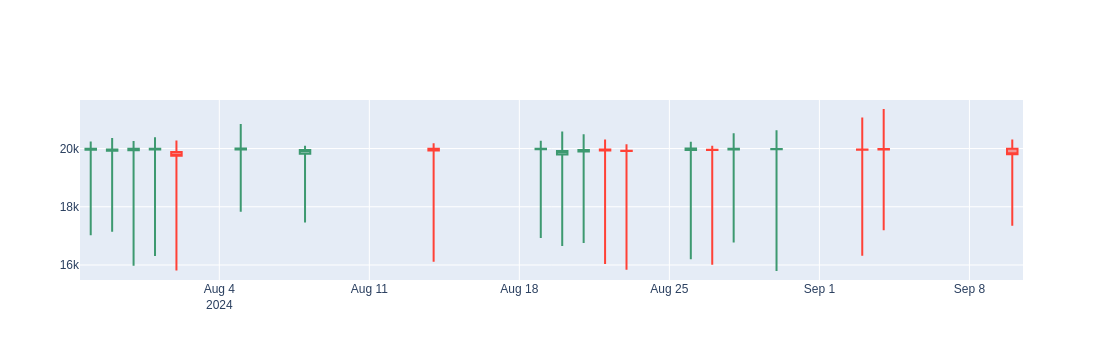

In [524]:
create_candle_stick(portfolio[ticker+[col for col in portfolio.columns if re.search(".*portfolio.*", col)]], date='2024-09-10')

In [516]:
portfolio_rand = portfolio_rand[::-1]

In [525]:
def create_candle_stick_rand(df_portfolio, date='2024-01-15', period=30):
    # Backtest the tool for the last 30 days
    df_portfolio = df_portfolio[datetime.strptime(date, '%Y-%m-%d'):]
    df_portfolio = df_portfolio.iloc[:20]
    # print(df_portfolio.tail())
    fig = go.Figure(data=[go.Candlestick(x=df_portfolio.index,
                open=df_portfolio['portfolio_buy_rand'], high=df_portfolio['portfolio_max_rand'],
                low=df_portfolio['portfolio_min_rand'], close=df_portfolio['portfolio_curr_rand'])
                     ])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

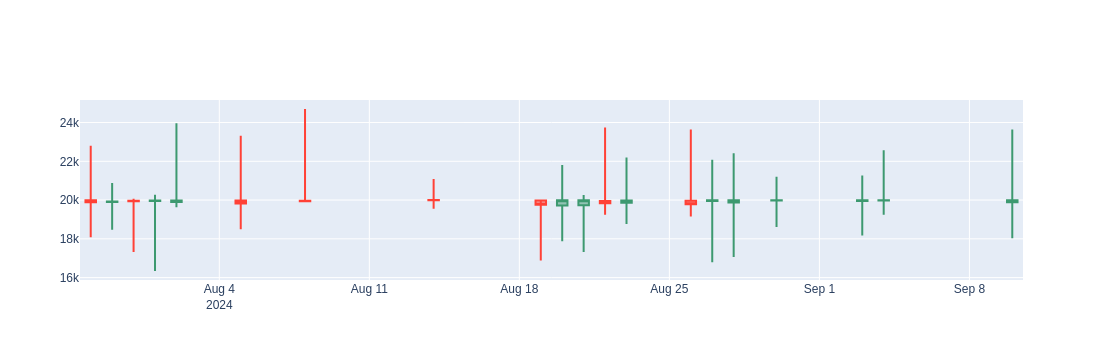

In [526]:
create_candle_stick_rand(portfolio_rand[ticker+[col for col in portfolio_rand.columns if re.search(".*portfolio.*", col)]], date='2024-11-07')

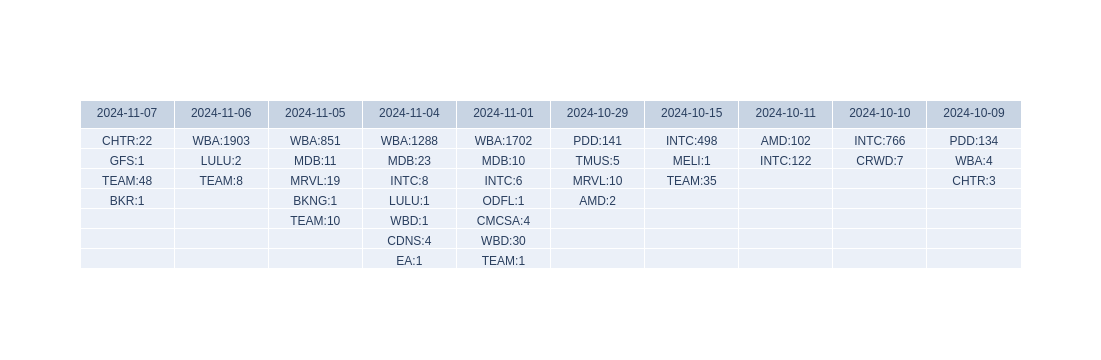

In [556]:
def list_of_list(window):
    # print(window.keys())
    return list(f"{k}:{v}" for k, v in window.items())

    
# Sample data
header_values = portfolio.iloc[:10].index.strftime("%Y-%m-%d")
cell_values = portfolio.iloc[:10]["portfolio"].apply(list_of_list).to_frame().values.tolist() #[['John', 25, 'New York'], ['Mary', 30, 'Los Angeles'], ['Bob', 35, 'Chicago']]
cell_values = [c[0] for c in cell_values]
# Create the table figure
fig = go.Figure(data=[go.Table(
    header=dict(values=header_values),
    cells=dict(values=cell_values)
)])

# Display the figure

fig.show()

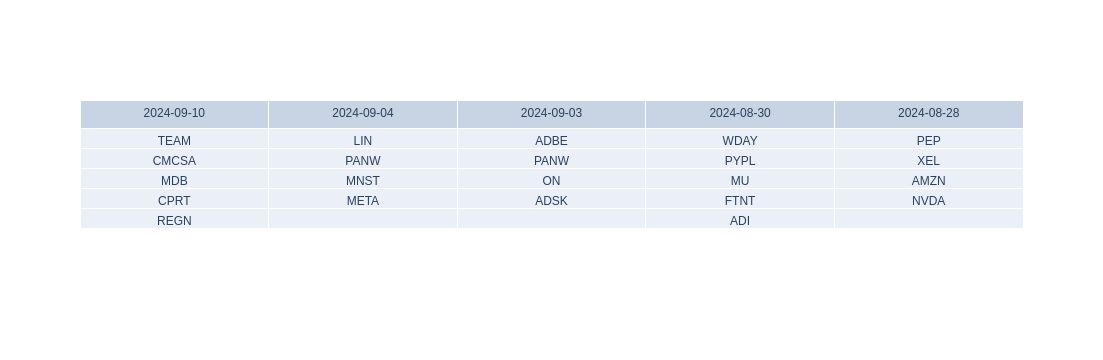

In [519]:
def list_of_list(window):
    # print(window.keys())
    return list(window.keys())

    
# Sample data
header_values = portfolio_rand[:5].index.strftime("%Y-%m-%d")
cell_values = portfolio_rand[:5]["portfolio"].apply(list_of_list).to_frame().values.tolist() #[['John', 25, 'New York'], ['Mary', 30, 'Los Angeles'], ['Bob', 35, 'Chicago']]
cell_values = [c[0] for c in cell_values]
# Create the table figure
fig = go.Figure(data=[go.Table(
    header=dict(values=header_values),
    cells=dict(values=cell_values)
)])

# Display the figure
fig.show()

In [168]:
# blacklit_df[blacklit_df["MDB_expected_upward_movement_interval"]==(np.NaN, np.NaN)]["MDB_expected_upward_movement_interval"]

Series([], Name: MDB_expected_upward_movement_interval, dtype: object)

In [528]:
len(portfolio)

46

In [529]:
import seaborn as sns
import pandas as pd

# Create a DataFrame
data = pd.DataFrame({'Value': np.concatenate([data1, data2, data3]),
                     'Group': ['Data 1'] * len(data1) + ['Data 2'] * len(data2) + ['Data 3'] * len(data3)})

# Plot the KDEs
sns.kdeplot(data=data, x='Value', hue='Group')
plt.show()

NameError: name 'data1' is not defined

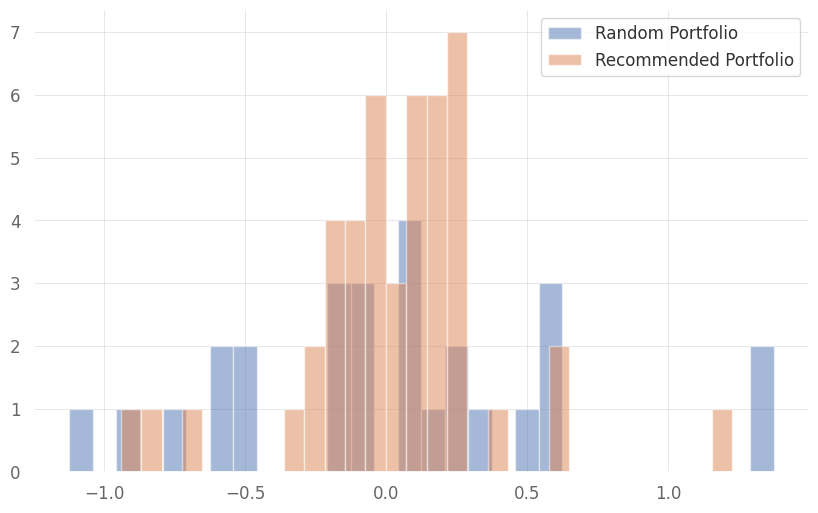

In [546]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
data1 = ((portfolio_rand["portfolio_curr_rand"] - portfolio_rand["portfolio_buy_rand"])/portfolio_rand["portfolio_buy_rand"])*100 #np.random.normal(0, 1, 1000)
data2 = ((portfolio["portfolio_curr"] - portfolio["portfolio_buy"])/portfolio["portfolio_buy"])*100 #np.random.normal(2, 1, 1000)
# data3 = np.random.normal(-2, 1, 1000)

# Plot the histograms
plt.hist(data1, bins=30, alpha=0.5, label='Random Portfolio')
plt.hist(data2, bins=30, alpha=0.5, label='Recommended Portfolio')
# plt.hist(data3, bins=30, alpha=0.5, label='Data 3')

plt.legend()
plt.show()

In [540]:
portfolio_rand["portfolio_curr_rand"]-portfolio_rand["portfolio_buy_rand"]

Date
2024-09-10    107.595289
2024-09-04     15.455685
2024-09-03     45.663582
2024-08-30     10.700409
2024-08-28    114.157112
2024-08-27     49.747574
2024-08-26   -181.536827
2024-08-23    105.051414
2024-08-22   -108.792204
2024-08-21    257.018500
2024-08-20    270.762196
2024-08-19   -224.505543
2024-08-14    -10.871422
2024-08-08    -21.351841
2024-08-05   -147.837322
2024-08-02     69.602310
2024-08-01     19.776966
2024-07-31    -25.656784
2024-07-30     29.154716
2024-07-29   -101.383736
2024-07-26   -104.907543
2024-07-17    -26.378113
2024-07-16    -40.268129
2024-07-15    114.446411
2024-07-12   -124.073204
2024-07-11     11.580498
2024-07-10    -13.892490
dtype: float64

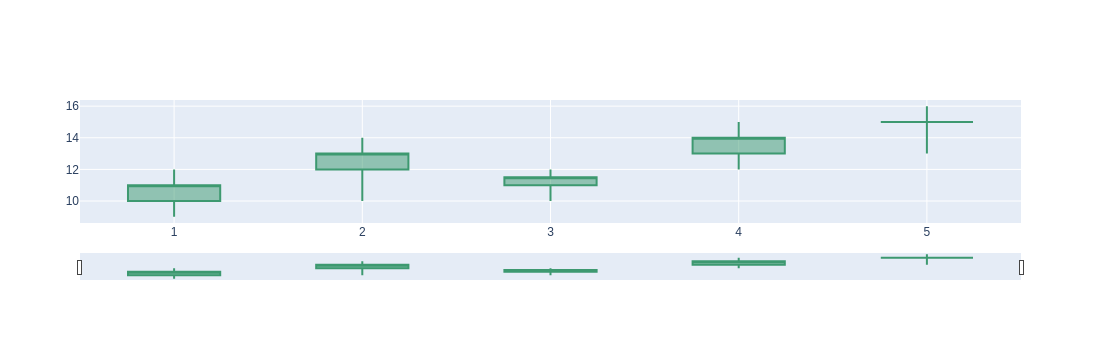

In [543]:
import plotly.graph_objects as go



# Sample data

x = [1, 2, 3, 4, 5]

open_prices = [10, 12, 11, 13, 15]

high_prices = [12, 14, 12, 15, 16]

low_prices = [9, 10, 10, 12, 13]

close_prices = [11, 13, 11.5, 14, 15]



fig = go.Figure(data=[go.Candlestick(x=x, open=open_prices, high=high_prices, low=low_prices, close=close_prices,

                                    hovertext=["Buy Date: " + "2024-05-01" + "<br>High: " + str(h) + "<br>Low: " + str(l) + "<br>Close: " + str(c) 

                                              for o, h, l, c in zip(open_prices, high_prices, low_prices, close_prices)])])



fig.show()

In [549]:
portfolio["portfolio"]

Date
2024-11-07         {'CHTR': 22, 'GFS': 1, 'TEAM': 48, 'BKR': 1}
2024-11-06                  {'WBA': 1903, 'LULU': 2, 'TEAM': 8}
2024-11-05    {'WBA': 851, 'MDB': 11, 'MRVL': 19, 'BKNG': 1,...
2024-11-04    {'WBA': 1288, 'MDB': 23, 'INTC': 8, 'LULU': 1,...
2024-11-01    {'WBA': 1702, 'MDB': 10, 'INTC': 6, 'ODFL': 1,...
2024-10-29        {'PDD': 141, 'TMUS': 5, 'MRVL': 10, 'AMD': 2}
2024-10-15                 {'INTC': 498, 'MELI': 1, 'TEAM': 35}
2024-10-11                            {'AMD': 102, 'INTC': 122}
2024-10-10                             {'INTC': 766, 'CRWD': 7}
2024-10-09                    {'PDD': 134, 'WBA': 4, 'CHTR': 3}
2024-10-08                              {'PDD': 129, 'CHTR': 4}
2024-10-07          {'PDD': 94, 'CHTR': 6, 'CEG': 13, 'WBA': 3}
2024-10-01    {'ADSK': 3, 'INTC': 49, 'TSLA': 45, 'AMD': 4, ...
2024-09-30    {'INTC': 122, 'AMD': 30, 'WBA': 25, 'EXC': 4, ...
2024-09-27                    {'AMD': 2, 'TSLA': 67, 'PDD': 16}
2024-09-17         {'REGN': 14, 'ME

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 

#### 